<a href="https://colab.research.google.com/github/badgiojuni/DL_with_pytorch/blob/main/Insurance_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
DATASET_URL = "https://gist.github.com/BirajCoder/5f068dfe759c1ea6bdfce9535acdb72d/raw/c84d84e3c80f93be67f6c069cbdc0195ec36acbd/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

  0%|          | 0/54288 [00:00<?, ?it/s]

In [3]:
dataframe_raw = pd.read_csv(DATA_FILENAME)

In [4]:
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
print(dataframe_raw.shape)
print(dataframe_raw.dtypes)

(1338, 7)
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


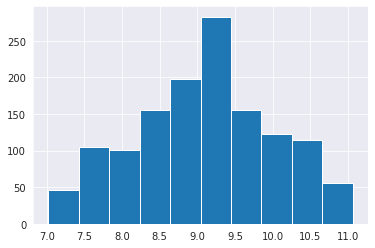

In [6]:
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
np.log(dataframe_raw.charges).hist()

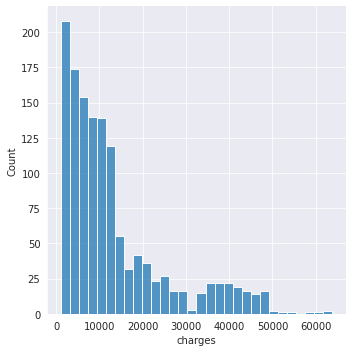

In [7]:
sns.displot(dataframe_raw.charges, kde=False);

In [8]:
input_cols = list(dataframe_raw.columns)[:-1]
categorical_cols = ['sex', 'smoker', 'region']
target_col = ['charges']

In [9]:
def df_to_array(df):
  df1 = df.copy(deep=True)
  for col in categorical_cols:
    df1[col] = df1[col].astype('category').cat.codes
  input_array, target_array = df1[input_cols].values, df1[target_col].values
  return input_array, target_array

In [10]:
X, y = df_to_array(dataframe_raw)

In [11]:
inputs, target = torch.from_numpy(np.float32(X)), torch.from_numpy(np.float32(y))

In [12]:
inputs.dtype

torch.float32

In [13]:
full_dataset = TensorDataset(inputs, target)

In [14]:
random_prop = np.random.uniform(0.1,0.2)
valid_ds_len = int(np.floor(random_prop * len(full_dataset)))

In [15]:
from torch.utils.data import random_split
random_prop = np.random.uniform(0.1,0.2)
test_ds_len = int(np.floor(random_prop * len(full_dataset)))
train_ds, valid_ds = random_split(full_dataset, [len(full_dataset)- valid_ds_len, valid_ds_len,])

In [16]:
from torch.utils.data import DataLoader
b_size = 32
train_loader = DataLoader(train_ds, batch_size = b_size, shuffle=True)
valid_loader = DataLoader(valid_ds, 2*b_size)

In [17]:
for xb, yb in train_loader:
  print('inputs:', xb)
  print('labels:', yb)
  break

inputs: tensor([[28.0000,  1.0000, 37.1000,  1.0000,  0.0000,  3.0000],
        [43.0000,  0.0000, 24.7000,  2.0000,  1.0000,  1.0000],
        [31.0000,  0.0000, 32.6800,  1.0000,  0.0000,  1.0000],
        [32.0000,  1.0000, 46.5300,  2.0000,  0.0000,  2.0000],
        [52.0000,  1.0000, 32.2050,  3.0000,  0.0000,  0.0000],
        [39.0000,  0.0000, 34.1000,  3.0000,  0.0000,  3.0000],
        [57.0000,  1.0000, 40.3700,  0.0000,  0.0000,  2.0000],
        [23.0000,  0.0000, 28.3100,  0.0000,  1.0000,  1.0000],
        [21.0000,  1.0000, 35.5300,  0.0000,  0.0000,  2.0000],
        [42.0000,  1.0000, 24.8600,  0.0000,  0.0000,  2.0000],
        [19.0000,  1.0000, 20.4250,  0.0000,  0.0000,  1.0000],
        [28.0000,  1.0000, 33.0000,  3.0000,  0.0000,  2.0000],
        [54.0000,  0.0000, 23.0000,  3.0000,  0.0000,  3.0000],
        [55.0000,  1.0000, 27.6450,  0.0000,  0.0000,  1.0000],
        [28.0000,  1.0000, 23.8000,  2.0000,  0.0000,  3.0000],
        [37.0000,  0.0000, 34.80

In [18]:
input_size = inputs.shape[1]
output_size = target.shape[1]

In [19]:
class InsuranceModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(in_features=input_size, out_features=output_size)

  def forward(self, inputs):
    out = self.linear(inputs)
    return out
  
  def training_step(self, batch):
    inputs, labels = batch
    preds = self(inputs)
    loss = nn.functional.l1_loss(preds, labels)
    return loss
  
  def validation_step(self, batch):
    inputs, labels = batch
    preds = self(inputs)
    loss = nn.functional.l1_loss(preds, labels)
    return {'val_loss': loss.detach()}
  
  def validation_epoch_end(self, outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    return {"val.loss": epoch_loss}
  
  def epoch_end(self, epoch, result, num_epochs):
    if (epoch + 1) % 50 == 0 or epoch == (num_epochs-1) :
      print(f"A la {epoch+1} epoch, la fonction de cout du dataset de validation est de {result['val.loss']:.4f}")

In [20]:
model = InsuranceModel()

In [21]:
for batch in train_loader:
  a = model.training_step(batch)
  break


*Train the model:*

In [22]:
def evaluate(model, data_loader):
  outputs = [model.validation_step(batch) for batch in data_loader]
  return model.validation_epoch_end(outputs)

def fit(model, nb_epoch, data_train_load, data_valid_load, lr, opt_func=torch.optim.SGD):
  history=[]
  opt = opt_func(model.parameters(), lr=lr)
  for epoch in range(nb_epoch):
    for batch in data_train_load:
      loss = model.training_step(batch)
      loss.backward()
      opt.step()
      opt.zero_grad()
    epoch_eval = evaluate(model, data_valid_load)
    model.epoch_end(epoch, epoch_eval, nb_epoch)
    history.append(epoch_eval)
  return history

In [23]:
nb_epoch=500
lr = 1e-2
history = fit(model, nb_epoch, train_loader, valid_loader, lr)

A la 50 epoch, la fonction de cout du dataset de validation est de 6526.1450
A la 100 epoch, la fonction de cout du dataset de validation est de 6339.8569
A la 150 epoch, la fonction de cout du dataset de validation est de 6221.9888
A la 200 epoch, la fonction de cout du dataset de validation est de 6181.0444
A la 250 epoch, la fonction de cout du dataset de validation est de 6173.6777
A la 300 epoch, la fonction de cout du dataset de validation est de 6171.4922
A la 350 epoch, la fonction de cout du dataset de validation est de 6170.2690
A la 400 epoch, la fonction de cout du dataset de validation est de 6166.8218
A la 450 epoch, la fonction de cout du dataset de validation est de 6164.5415
A la 500 epoch, la fonction de cout du dataset de validation est de 6161.8789


In [24]:
def make_preds(input, target, model):
  input = input.unsqueeze(0)
  pred = model(input)
  prediction = pred[0].detach()
  print("Input:", input)
  print("Target:", target)
  print("Prediction:", prediction)